In [1]:
import pickle
import datetime
import MySQLdb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as MeanSE
from sklearn.metrics import mean_absolute_error as MeanAE
from sklearn.metrics import median_absolute_error as MedianAE
from sklearn.metrics import r2_score, explained_variance_score
import matplotlib.pyplot as plt

In [8]:
# 没有年龄和性别
# Preliminary query for feature data
print('start MYSQL')
sql_test = """
    SELECT
        IF(dxt.AliasName = '', 'OTHERDX', dxt.AliasName) DiagnosisName,
        DATE(ap.ScheduledStartTime) ap_date,
        ap.AppointmentSerNum,
        ap.AliasSerNum,
        ap.PatientSerNum,
        ap.ScheduledStartTime,
        ap.ScheduledEndTime,
        ap.ActualStartDate,
        ap.ActualEndDate,
        IF((ap.ActualEndDate IN ('0000-00-00 00:00:00','1970-01-01 00:00:00'))
            OR (DATE(ap.ActualStartDate) != DATE(ap.ActualEndDate)),
        '0', TIMESTAMPDIFF(MINUTE, ap.ActualStartDate, ap.ActualEndDate)) duration,
        TIMESTAMPDIFF(MINUTE, ap.ScheduledStartTime, ap.ScheduledEndTime) allocated,
        co.CourseSerNum,
        pd.DoctorSerNum,
        pl.PlanSerNum,
        IF(pl.TreatmentOrientation = '', 'NULL', pl.TreatmentOrientation) orientation
    FROM
        Appointment ap
    INNER JOIN Diagnosis dx
        ON dx.DiagnosisSerNum = ap.DiagnosisSerNum
    LEFT JOIN DiagnosisTranslation dxt
        ON dxt.DiagnosisCode = dx.DiagnosisCode
    INNER JOIN Patient pt
        ON pt.PatientSerNum = ap.PatientSerNum
    INNER JOIN Course co
        ON co.PatientSerNum = pt.PatientSerNum
    INNER JOIN Plan pl
        ON pl.CourseSerNum = co.CourseSerNum
    INNER JOIN PatientDoctor pd
        ON pd.PatientSerNum = ap.PatientSerNum
    WHERE
        ap.Status LIKE '%%Completed%%'
    AND ap.State = 'Active'
    AND ap.ActualStartDate NOT IN ('0000-00-00 00:00:00','1970-01-01 00:00:00')
    AND pd.PrimaryFlag = 1
    AND pd.OncologistFlag = 1
    AND pl.Status IN ('TreatApproval')
    AND co.CourseSerNum = (
        SELECT co2.CourseSerNum
        FROM Course co2
        INNER JOIN Plan pl2
        ON (    pl2.CourseSerNum = co2.CourseSerNum
            AND pl2.Status IN ('TreatApproval') )
        WHERE
            ap.ActualStartDate  > co2.StartDateTime
        AND co2.CourseId        NOT LIKE '%%QA%%'
        AND co.PatientSerNum    = co2.PatientSerNum
        ORDER BY co2.StartDateTime DESC
        LIMIT 1 )
    AND ap.AliasSerNum IN ('31', '23')
    AND ap.ScheduledStartTime > '2015-01-01 00:00:00'
    GROUP BY
        pt.PatientSerNum, ap.ScheduledStartTime
    ORDER BY
        ap.AppointmentSerNum ASC
"""
# LIMIT1: 在某些情况下，如果明知道查询结果只有一个，SQL语句中使用LIMIT 1会提高查询效率


start MYSQL


In [9]:
# Connect to the MySQL database
def getSQLtest(sql):
    # Connect to the MySQL database
    db = MySQLdb.connect(host='localhost',
                         port=3306,
                         user='root',
                         passwd='root',
                         db='originaldata')
    db_cursor = db.cursor(MySQLdb.cursors.DictCursor)
    sql0 = """
         set sql_mode = 'STRICT_TRANS_TABLES,NO_ZERO_IN_DATE,NO_ZERO_DATE,ERROR_FOR_DIVISION_BY_ZERO,NO_ENGINE_SUBSTITUTION';
    """       
    db_cursor.execute(sql0)
    db_cursor.execute(sql)
    db_results = db_cursor.fetchall()
    db_cursor.close()
    print ("Fetched Preliminary query results")
    print ("Number of results: " + str(len(db_results)))
    return db_results

In [11]:
print("Executing query...")
db_pat = getSQLtest(sql_test)
print('Finish!')

Executing query...
Fetched Preliminary query results
Number of results: 144873
Finish!


In [4]:
print('Start!')
raw_test = {}
all_datetime_31 = set()
all_datetime_23 = set()
patient_31 = set()
patient_23 = set()
count = 1
# Loop through each result
for row in db_pat:

    # In this next instance, there may be duplicate appointment serials for each patient
    # because of multiple plans for each course (or other duplicate info). We must concatenate all duplicates
    # into one list because all of them together contribute to ONE appointment duration.
    # If we didn't do this then we would be saying that each duplicate contributes to
    # it's own duration, which is not accurate. For ex: one appt has FP1_BREAST and FP1_EL.
    # Separately, each of them has an assigned duration (2 query results), let's say 10 minutes.
    # This is ONE appt, so we can't say that each plan is 10 mins long. In fact,
    # BOTH plans together contribute to the 10 minutes.
    
#        在下一个例子中，由于每个疗程有多个计划(或其他重复信息)，每个病人可能有重复的预约序列。
#        我们必须将所有的副本连接到一个列表中，因为所有这些副本一起构成一个约会持续时间。
#        如果我们不这样做，那么我们就会说每个副本都贡献了它自己的持续时间，这是不准确的。
#        例如:一个appt有FP1_BREAST和FP1_EL。另外，它们每个都有一个指定的持续时间(2个查询结果)，比如10分钟。
#        这是一个appt，所以我们不能说每个计划都是10分钟。事实上，这两种计划加在一起就是10分钟。
    
    
    # Retrieve row params
    diagnosis = str(row['DiagnosisName'])
    appt_date = row['ap_date']
    alias_ser = int(row['AliasSerNum'])
    patient_ser = int(row['PatientSerNum'])
    appt_ser = str(row['AppointmentSerNum'])
    scheduled_start = row['ScheduledStartTime']
    scheduled_end = row['ScheduledEndTime']
    actual_start = row['ActualStartDate']
    actual_end = row['ActualEndDate']
    appt_allocated = int(row['allocated'])
    course = str(row['CourseSerNum'])
    oncologist = str(row['DoctorSerNum'])
    plan = str(row['PlanSerNum'])
    orientation = str(row['orientation'])
    appt_duration = int(row['duration'])
    
    
    if alias_ser == 31:
        patient_31.add(patient_ser)
        all_datetime_31.add(appt_date)
    else:
        patient_23.add(patient_ser)
        all_datetime_23.add(appt_date)
    
    if count%1000 == 0:
        print (count)
    count += 1
    # If current patient is not in the keys of patients,
    # Add a new key and assign the initial patient entry as defaultdicts
    if alias_ser not in raw_test.keys():            
        raw_test[alias_ser] = {
                appt_date:{
                        patient_ser:{
                                'scheduled_start': [scheduled_start],
                                'scheduled_end': [scheduled_end],
                                'actual_start': [actual_start],
                                'actual_end': [actual_end],
                                'diagnosis': [diagnosis],
                                'appt_allocated': [appt_allocated],
                                'course': [course],
                                'oncologist': [oncologist],
                                'plan': [plan],
                                'orientation': [orientation],
                                'appt_duration': [appt_duration]
                                }
                        }
                }
        continue


    if appt_date not in raw_test[alias_ser].keys():
        raw_test[alias_ser][appt_date] = {
                        patient_ser:{
                                'scheduled_start': [scheduled_start],
                                'scheduled_end': [scheduled_end],
                                'actual_start': [actual_start],
                                'actual_end': [actual_end],
                                'diagnosis': [diagnosis],
                                'appt_allocated': [appt_allocated],
                                'course': [course],
                                'oncologist': [oncologist],
                                'plan': [plan],
                                'orientation': [orientation],
                                'appt_duration': [appt_duration]
                                }
                }

        continue
    
    
    if patient_ser not in raw_test[alias_ser][appt_date].keys():
        raw_test[alias_ser][appt_date][patient_ser] = {
                'scheduled_start': [scheduled_start],
                'scheduled_end': [scheduled_end],
                'actual_start': [actual_start],
                'actual_end': [actual_end],
                'diagnosis': [diagnosis],
                'appt_allocated': [appt_allocated],
                'course': [course],
                'oncologist': [oncologist],
                'plan': [plan],
                'orientation': [orientation],
                'appt_duration': [appt_duration]
                }
        continue


    # At this point we've reached duplicate patient serials.
    # We append the respective parameters for the same appointment (ignoring duplicate parameters)
    raw_test[alias_ser][appt_date][patient_ser]['diagnosis']           = list(set(raw_test[alias_ser][appt_date][patient_ser]['diagnosis'] + [diagnosis]))
    raw_test[alias_ser][appt_date][patient_ser]['oncologist']          = list(set(raw_test[alias_ser][appt_date][patient_ser]['oncologist'] + [oncologist]))
    raw_test[alias_ser][appt_date][patient_ser]['course']              = list(set(raw_test[alias_ser][appt_date][patient_ser]['course'] + [course]))
    raw_test[alias_ser][appt_date][patient_ser]['plan']                = list(set(raw_test[alias_ser][appt_date][patient_ser]['plan'] + [plan]))
    raw_test[alias_ser][appt_date][patient_ser]['orientation']         = list(set(raw_test[alias_ser][appt_date][patient_ser]['orientation'] + [orientation]))
    raw_test[alias_ser][appt_date][patient_ser]['appt_allocated']      += [appt_allocated]
    raw_test[alias_ser][appt_date][patient_ser]['appt_duration']       += [appt_duration]    

print('Finish!')

Start!


NameError: name 'db_pat' is not defined

In [33]:
patient_23 = list(patient_23)
patient_31 = list(patient_31)
all_datetime_23 = list(all_datetime_23)
all_datetime_31 = list(all_datetime_31)

In [34]:
print(len(patient_23))
print(len(patient_31))

8333
9074


In [35]:
def transferDateToNum(time):
    hour = int(time.strftime('%H'))
    minute = int(time.strftime('%M'))
    Num = hour*60 + minute
    return Num - 450

In [36]:
# pat_oder_list = [PatientSerNum, schedule_start, schedule_end, actual_start, actual_end]
def getSequenceListAndDict(raw_test_venue_pat):
    all_time = {}
    raw_dict = raw_test_venue_pat
    for key in raw_dict.keys():
        scheduled_start = raw_dict[key]['scheduled_start'][0]
        scheduled_end = raw_dict[key]['scheduled_end'][0]
        actual_start = raw_dict[key]['actual_start'][0]
        actual_end = raw_dict[key]['actual_end'][0]
        all_time[scheduled_start] = [key, scheduled_end, actual_start, actual_end]

    pat_order_list = {}
    schedule_start_date_list = []
    schedule_start_list = []
    pat_list = []
    count = 0
    for key in sorted(all_time):
        pat_order_list[count] = [all_time[key][0], key, all_time[key][1], all_time[key][2], all_time[key][3]]
        schedule_start_date_list.append(key)
        schedule_start_list.append(transferDateToNum(key))
        pat_list.append(all_time[key][0])
        count = count + 1
    return pat_order_list, schedule_start_list, schedule_start_date_list, pat_list


In [37]:
def getPlotPatSequence1(n, pat, lengthOfDate):
    schedule_start = [0]*2*n + [transferDateToNum(pat[1])] + [0] * (2*lengthOfDate - 2*n - 1)
    actual_start = [0]*2*n + [transferDateToNum(pat[3])] + [0] * (2*lengthOfDate - 2*n - 1) 
    schedule_end = [0]*(2*n+1) + [transferDateToNum(pat[2])] + [0] * (2*lengthOfDate - (2*n+1) - 1)
    actual_end = [0]*(2*n+1) + [transferDateToNum(pat[4])] + [0] * (2*lengthOfDate - (2*n+1) - 1)
    return schedule_start, schedule_end, actual_start, actual_end


In [38]:
def getPlotPatSequence2(n, pat, lengthOfDate):
    schedule_start = [0]*2*n + [transferDateToNum(pat[1])] + [0] * (2*lengthOfDate - 2*n - 1)
    schedule_end = [0]*(2*n) + [transferDateToNum(pat[2])] + [0] * (2*lengthOfDate - (2*n) - 1)
    actual_start = [0]*(2*n+1) + [transferDateToNum(pat[3])] + [0] * (2*lengthOfDate - (2*n+1) - 1) 
    actual_end = [0]*(2*n+1) + [transferDateToNum(pat[4])] + [0] * (2*lengthOfDate - (2*n+1) - 1)
    return schedule_start, schedule_end, actual_start, actual_end


In [39]:
def plotDaySequence(pat_order_list, schedule_start_list, schedule_start_date_list, pat_list, mode = 2):
#    equal = []
    zero = []
    for key in pat_order_list.keys():
        if mode == 1:
            schedule_start, schedule_end, actual_start, actual_end = getPlotPatSequence1(key, pat_order_list[key], len(pat_order_list))
        else:
            schedule_start, schedule_end, actual_start, actual_end = getPlotPatSequence2(key, pat_order_list[key], len(pat_order_list))
        x = range(2*len(pat_order_list))
        if (max(actual_start) == 0) or (max(actual_end) == 0):
            plt.barh(x, schedule_end, color='green')
            plt.barh(x, schedule_start, color='white')
            
            n = schedule_start.index(max(schedule_start))
            actual_start = schedule_start
            actual_start[n+1] = max(schedule_start)
            actual_start[n] = 0
            
            plt.barh(x, actual_start, color='grey')
#            zero = zero + [key, key+1]
            zero.append(pat_order_list[key][0])
#            plt.barh(x, schedule_start, color='grey')
#            plt.barh(x, schedule_end, color='grey')
        else:
            plt.barh(x, schedule_end, color='green')
            plt.barh(x, schedule_start, color='white')
            plt.barh(x, actual_end, color='red')
            plt.barh(x, actual_start, color='white')
            
#            if max(schedule_start) < max(actual_start):
#                plt.barh(x, actual_start, color='red')
#                plt.barh(x, schedule_start, color='white')
#            elif max(schedule_start) == max(actual_start):
#                equal.append(key)
#                plt.barh(x, actual_start, color='red')
#                plt.barh(x, schedule_start, color='white')
#                print(key, 'Exist schedule_start = actual_start')
#            else:
#                plt.barh(x, schedule_start, color='darkred')
#                plt.barh(x, actual_start, color='white')
#                
#            if max(schedule_end) < max(actual_end):
#                plt.barh(x, actual_end, color='green')
#                plt.barh(x, schedule_end, color='white')
#            elif max(schedule_end) == max(actual_end):
#                equal.append(key)
#                plt.barh(x, actual_end, color='green')
#                plt.barh(x, schedule_end, color='white')
#                print(key, 'Exist schedule_start = actual_start')
#            else:
#                plt.barh(x, schedule_end, color='darkgreen')
#                plt.barh(x, actual_end, color='white')
    
    x_tick = [i.time() for i in schedule_start_date_list]
    plt.xticks(schedule_start_list, x_tick, rotation=90, fontsize=10)  # 数量多可以采用270度，数量少可以采用340度，得到更好的视图
    plt.yticks(range(0, 2*len(pat_order_list), 2), pat_list, rotation=0, fontsize=15)
#    plt.legend(loc="upper left")  # 防止label和图像重合显示不出来
#    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.ylabel('PatientSerNum')
    plt.xlabel('Time')
    plt.grid()
    plt.rcParams['savefig.dpi'] = 300  # 图片像素
    plt.rcParams['figure.dpi'] = 300 # 分辨率
    plt.rcParams['figure.figsize'] = (20,20)  # 尺寸
    appt_date_str = schedule_start_date_list[0].strftime('%Y-%m-%d')
    plt.title("%s Time Sequence_duration"%appt_date_str)
    #plt.savefig('C:\\Users\\WENDY\\Desktop\\waiting time\\我的代码\\Time_Sequence\\%s-%s-time_Sequence_duration.png'%(appt_date_str, 'First Treatment'), bbox_inches='tight')
    plt.show()
    return zero, appt_date_str

In [40]:
def pickleDump(data_to_pickle, filename, local_path):
    """ Function to write data to pickle format. """
    pickle.dump(data_to_pickle, open(filename, "wb+"))

# 读取预处理之后的数据，pickle文件

def pickle_load(pickle_to_data, filename, local_path):
    with open(local_path + pickle_to_data, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data = u.load()
    return data

In [41]:
patient_same = list(set(patient_23).intersection(set(patient_31)))
patient_different_31 = list(set(patient_31).difference(set(patient_23)))
patient_different_23 = list(set(patient_23).difference(set(patient_31)))
datetime_same = sorted(list(set(all_datetime_23).intersection(set(all_datetime_31))))
datetime_different_31 = sorted(list(set(all_datetime_31).difference(set(all_datetime_23))))
datetime_different_23 = sorted(list(set(all_datetime_23).difference(set(all_datetime_31))))


In [42]:
d = {'datetime_same': datetime_same, 'datetime_different_31': datetime_different_31,
     'datetime_different_23': datetime_different_23, 'patient_same': patient_same,
     'patient_different_31': patient_different_31, 'patient_different_23': patient_different_23}


In [43]:
my_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in d.items()]))
#my_df.to_csv('C:\\Users\\WENDY\\Desktop\\waiting time\\我的代码\\Time_Sequence\\Patient_And_Datetime.csv')


In [44]:
def getTXT(alias_ser, appt_date, appt_date_str, zero):
    dict_sort = sorted(raw_test[alias_ser][appt_date].items(), key=lambda x: x[1]['scheduled_start'])
    # raw_test[31][datetime.date(2016,1,8)]
    with open('C:\\Users\\WENDY\\Desktop\\waiting time\\我的代码\\Time_Sequence\\%s-%s.txt'%(appt_date_str, 'First Treatment'), 'w') as f:
        for term in dict_sort:
            f.write(str(term[0]))
            f.write('\n')
            for i in term[1].keys():
                f.write(i + '\t\t')
                f.write(str(term[1][i]))
                f.write('\n')
            f.write('\n\n\n')
        if zero == []:
            f.write('No missing Actual Datetime data!')
        else:
            f.write(str(zero))
            f.write('\nMiss Actual Datetime data!')
        f.close()

In [45]:
def plotAndGetData(alias_ser, appt_date):
    # raw_test[31][datetime.date(2016,1,8)]
    try:
        raw_test_venue_pat = raw_test[alias_ser][appt_date]
    except KeyError:
        print('No Key!')
    else:
        pat_order_list, schedule_start_list, schedule_start_date_list, pat_list = getSequenceListAndDict(raw_test_venue_pat)
        zero, appt_date_str = plotDaySequence(pat_order_list, schedule_start_list, schedule_start_date_list, pat_list)
        #getTXT(alias_ser, appt_date, appt_date_str, zero)


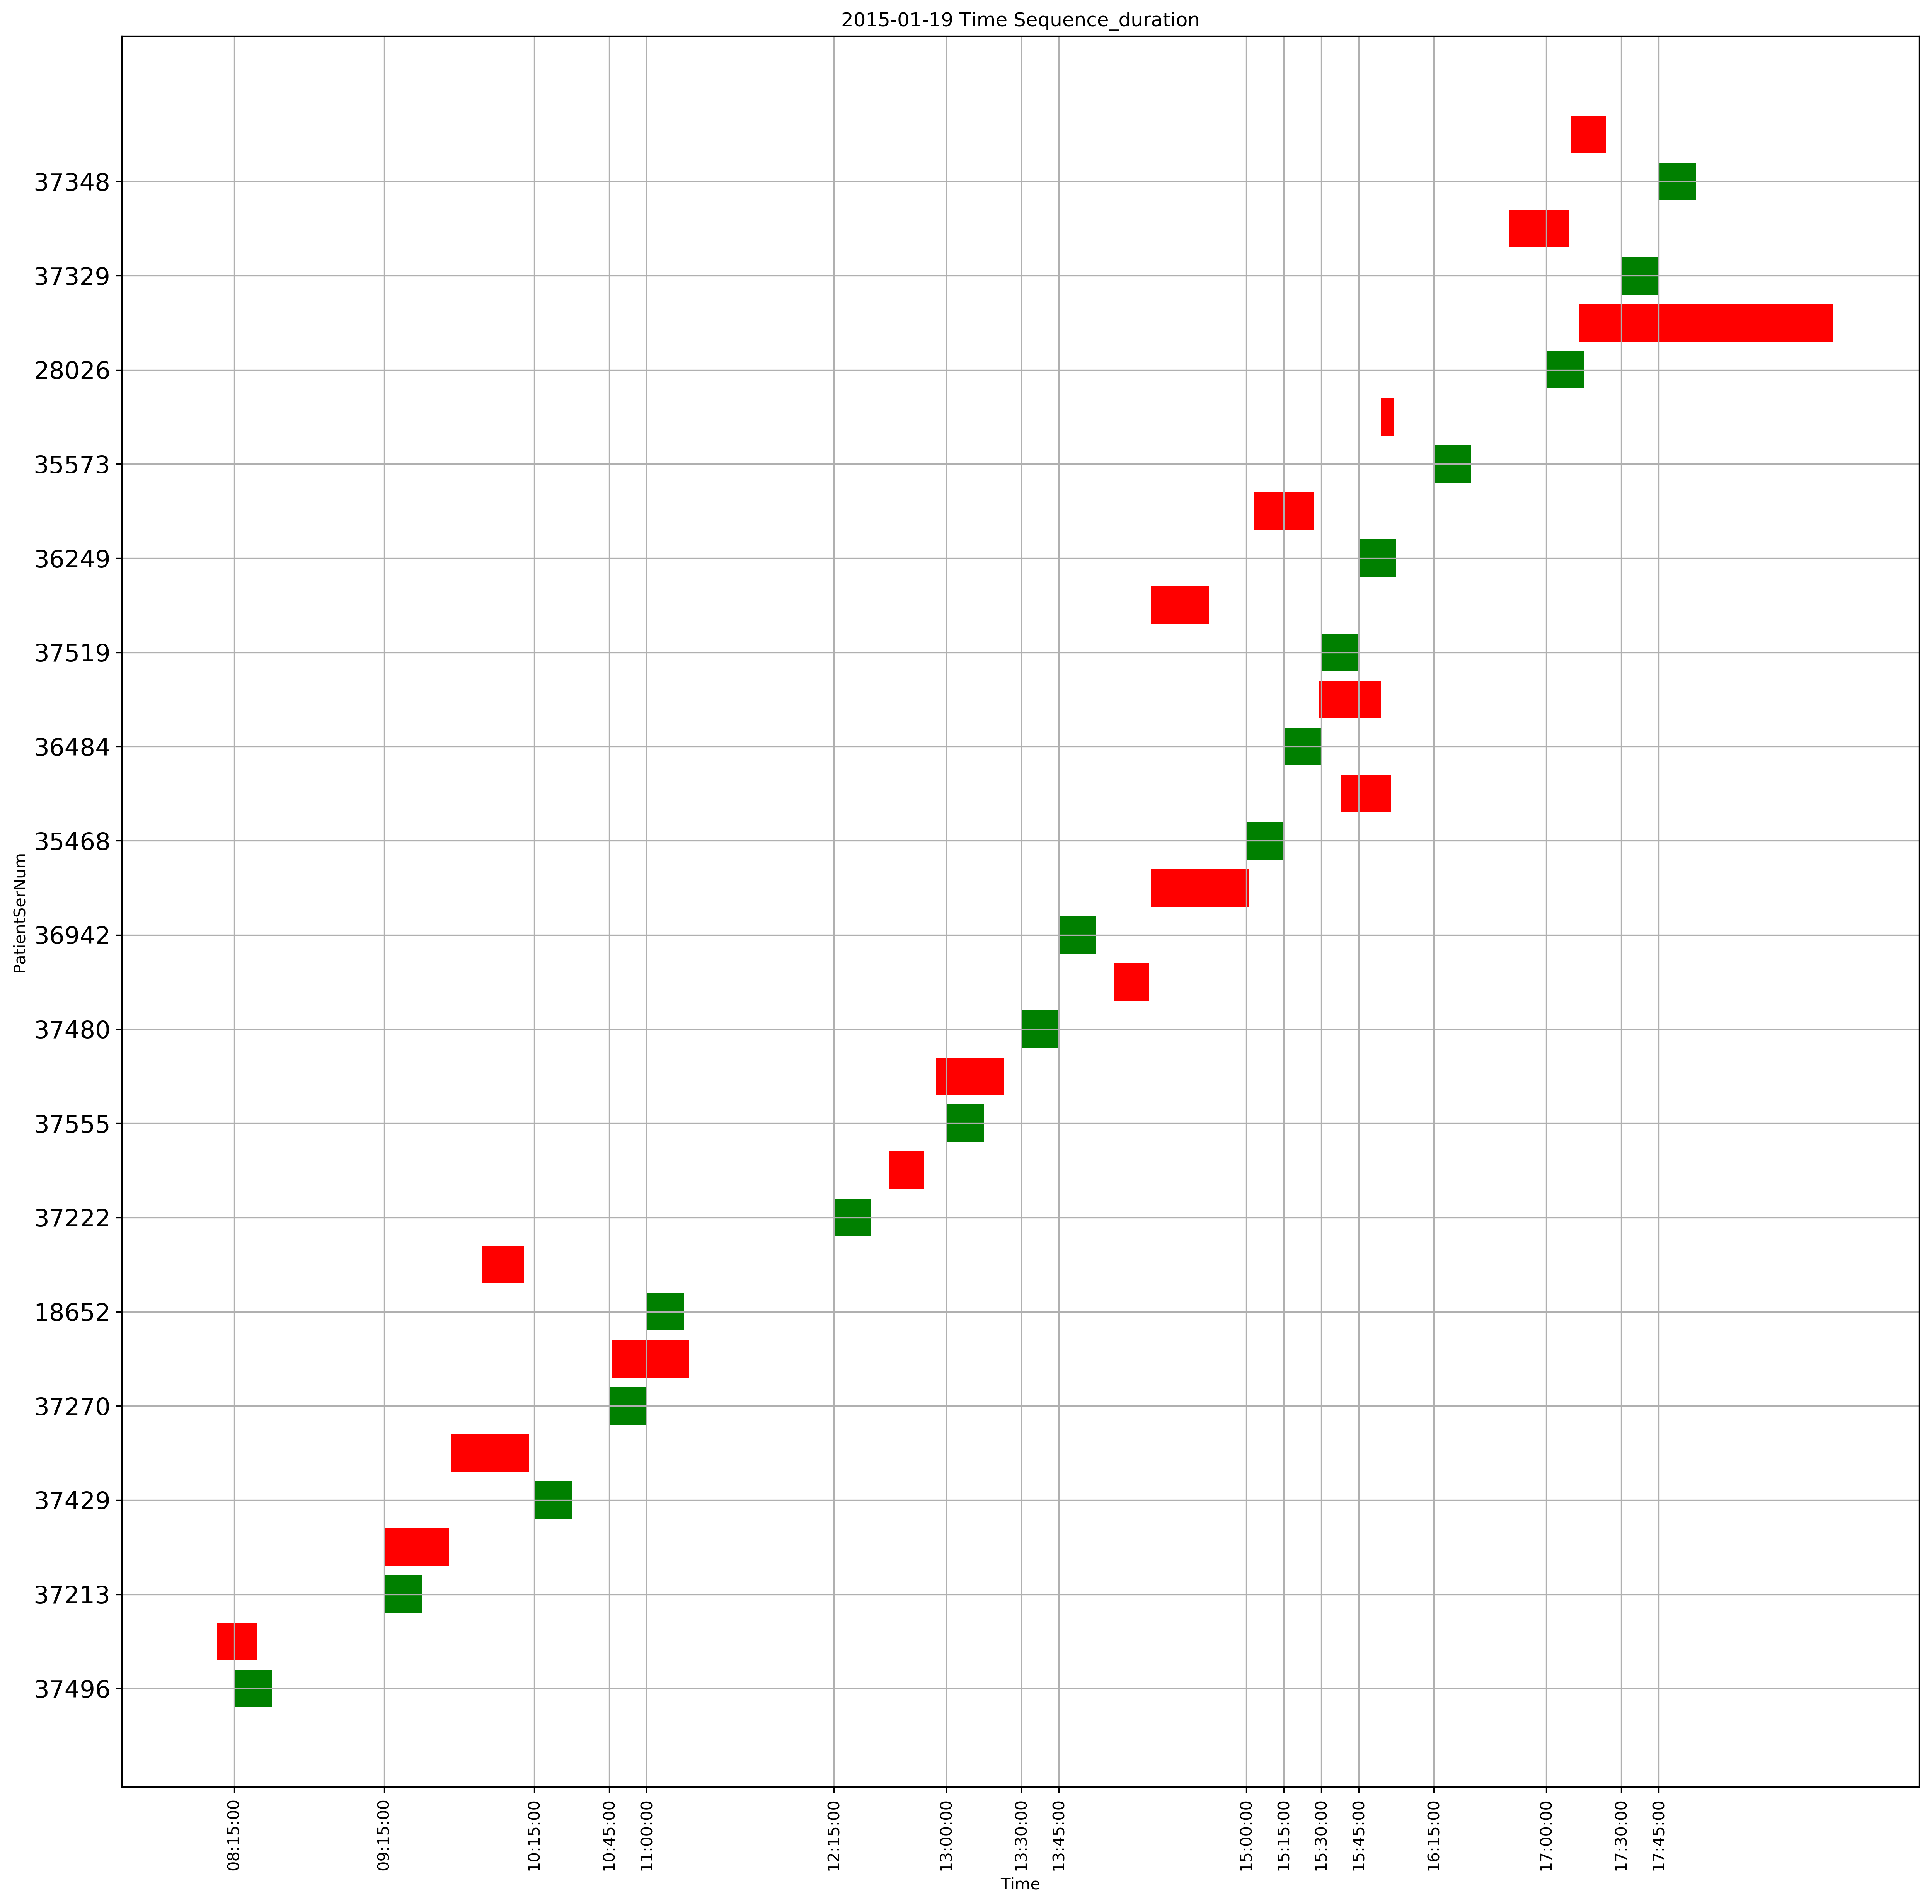

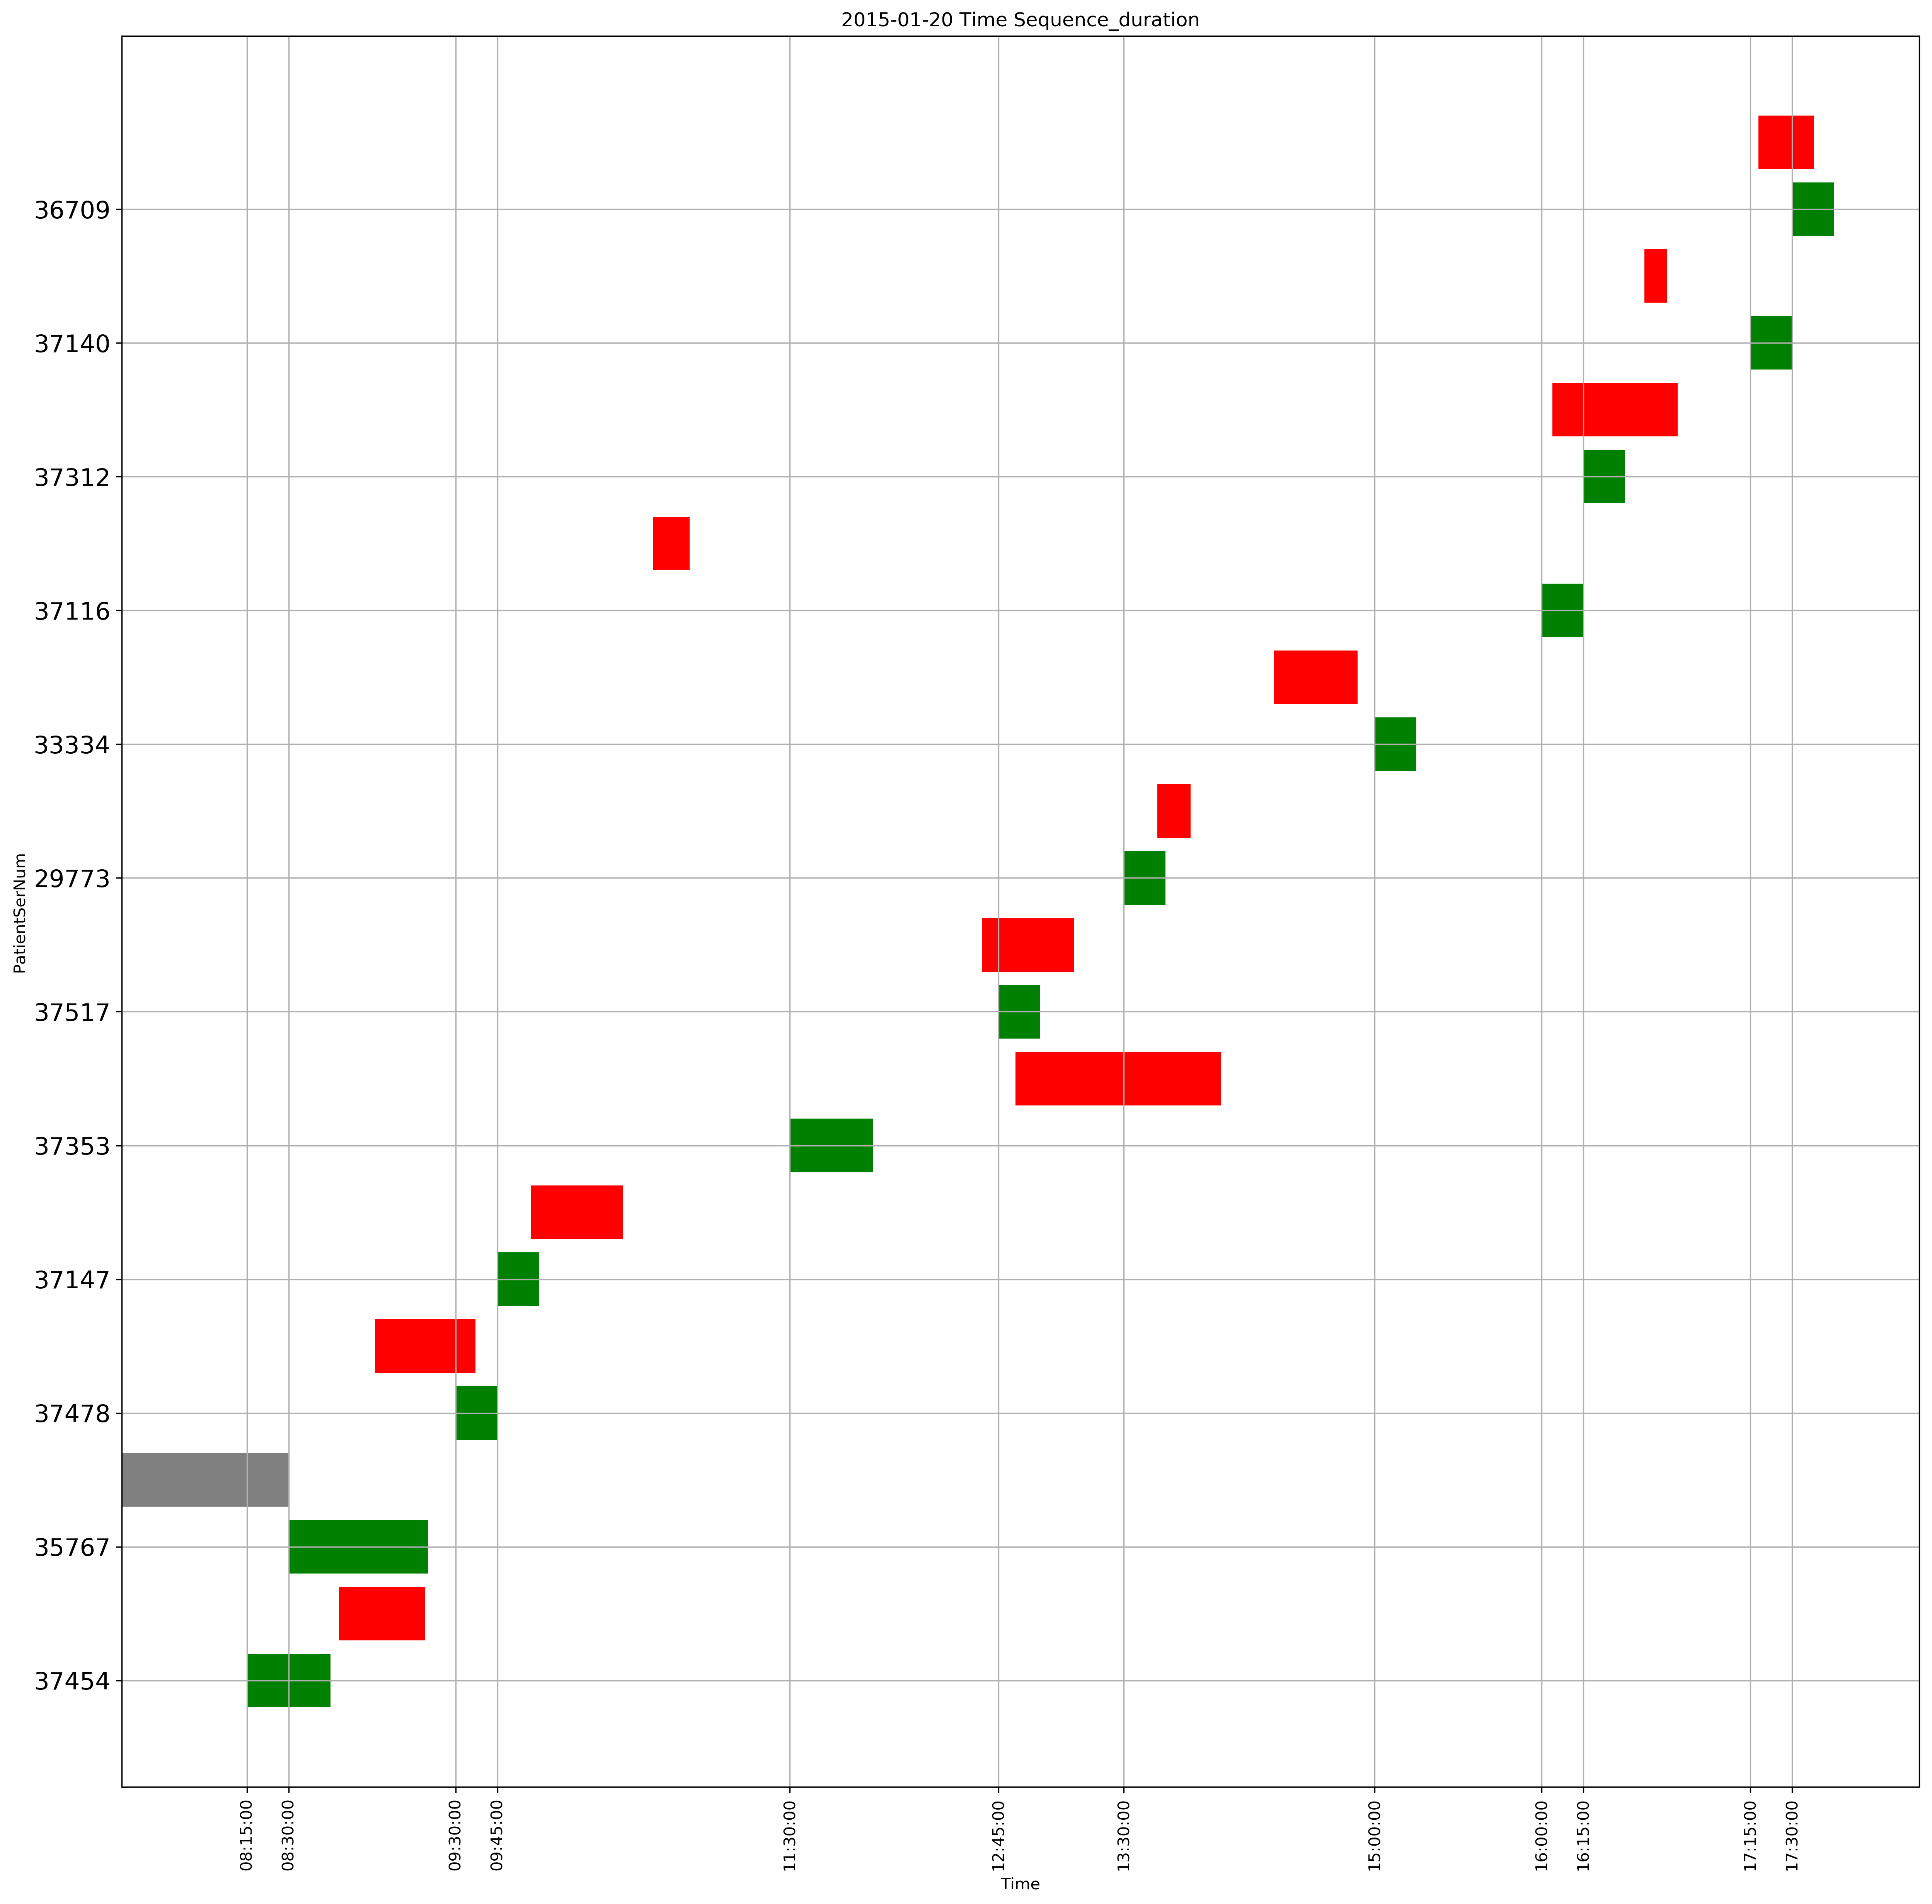

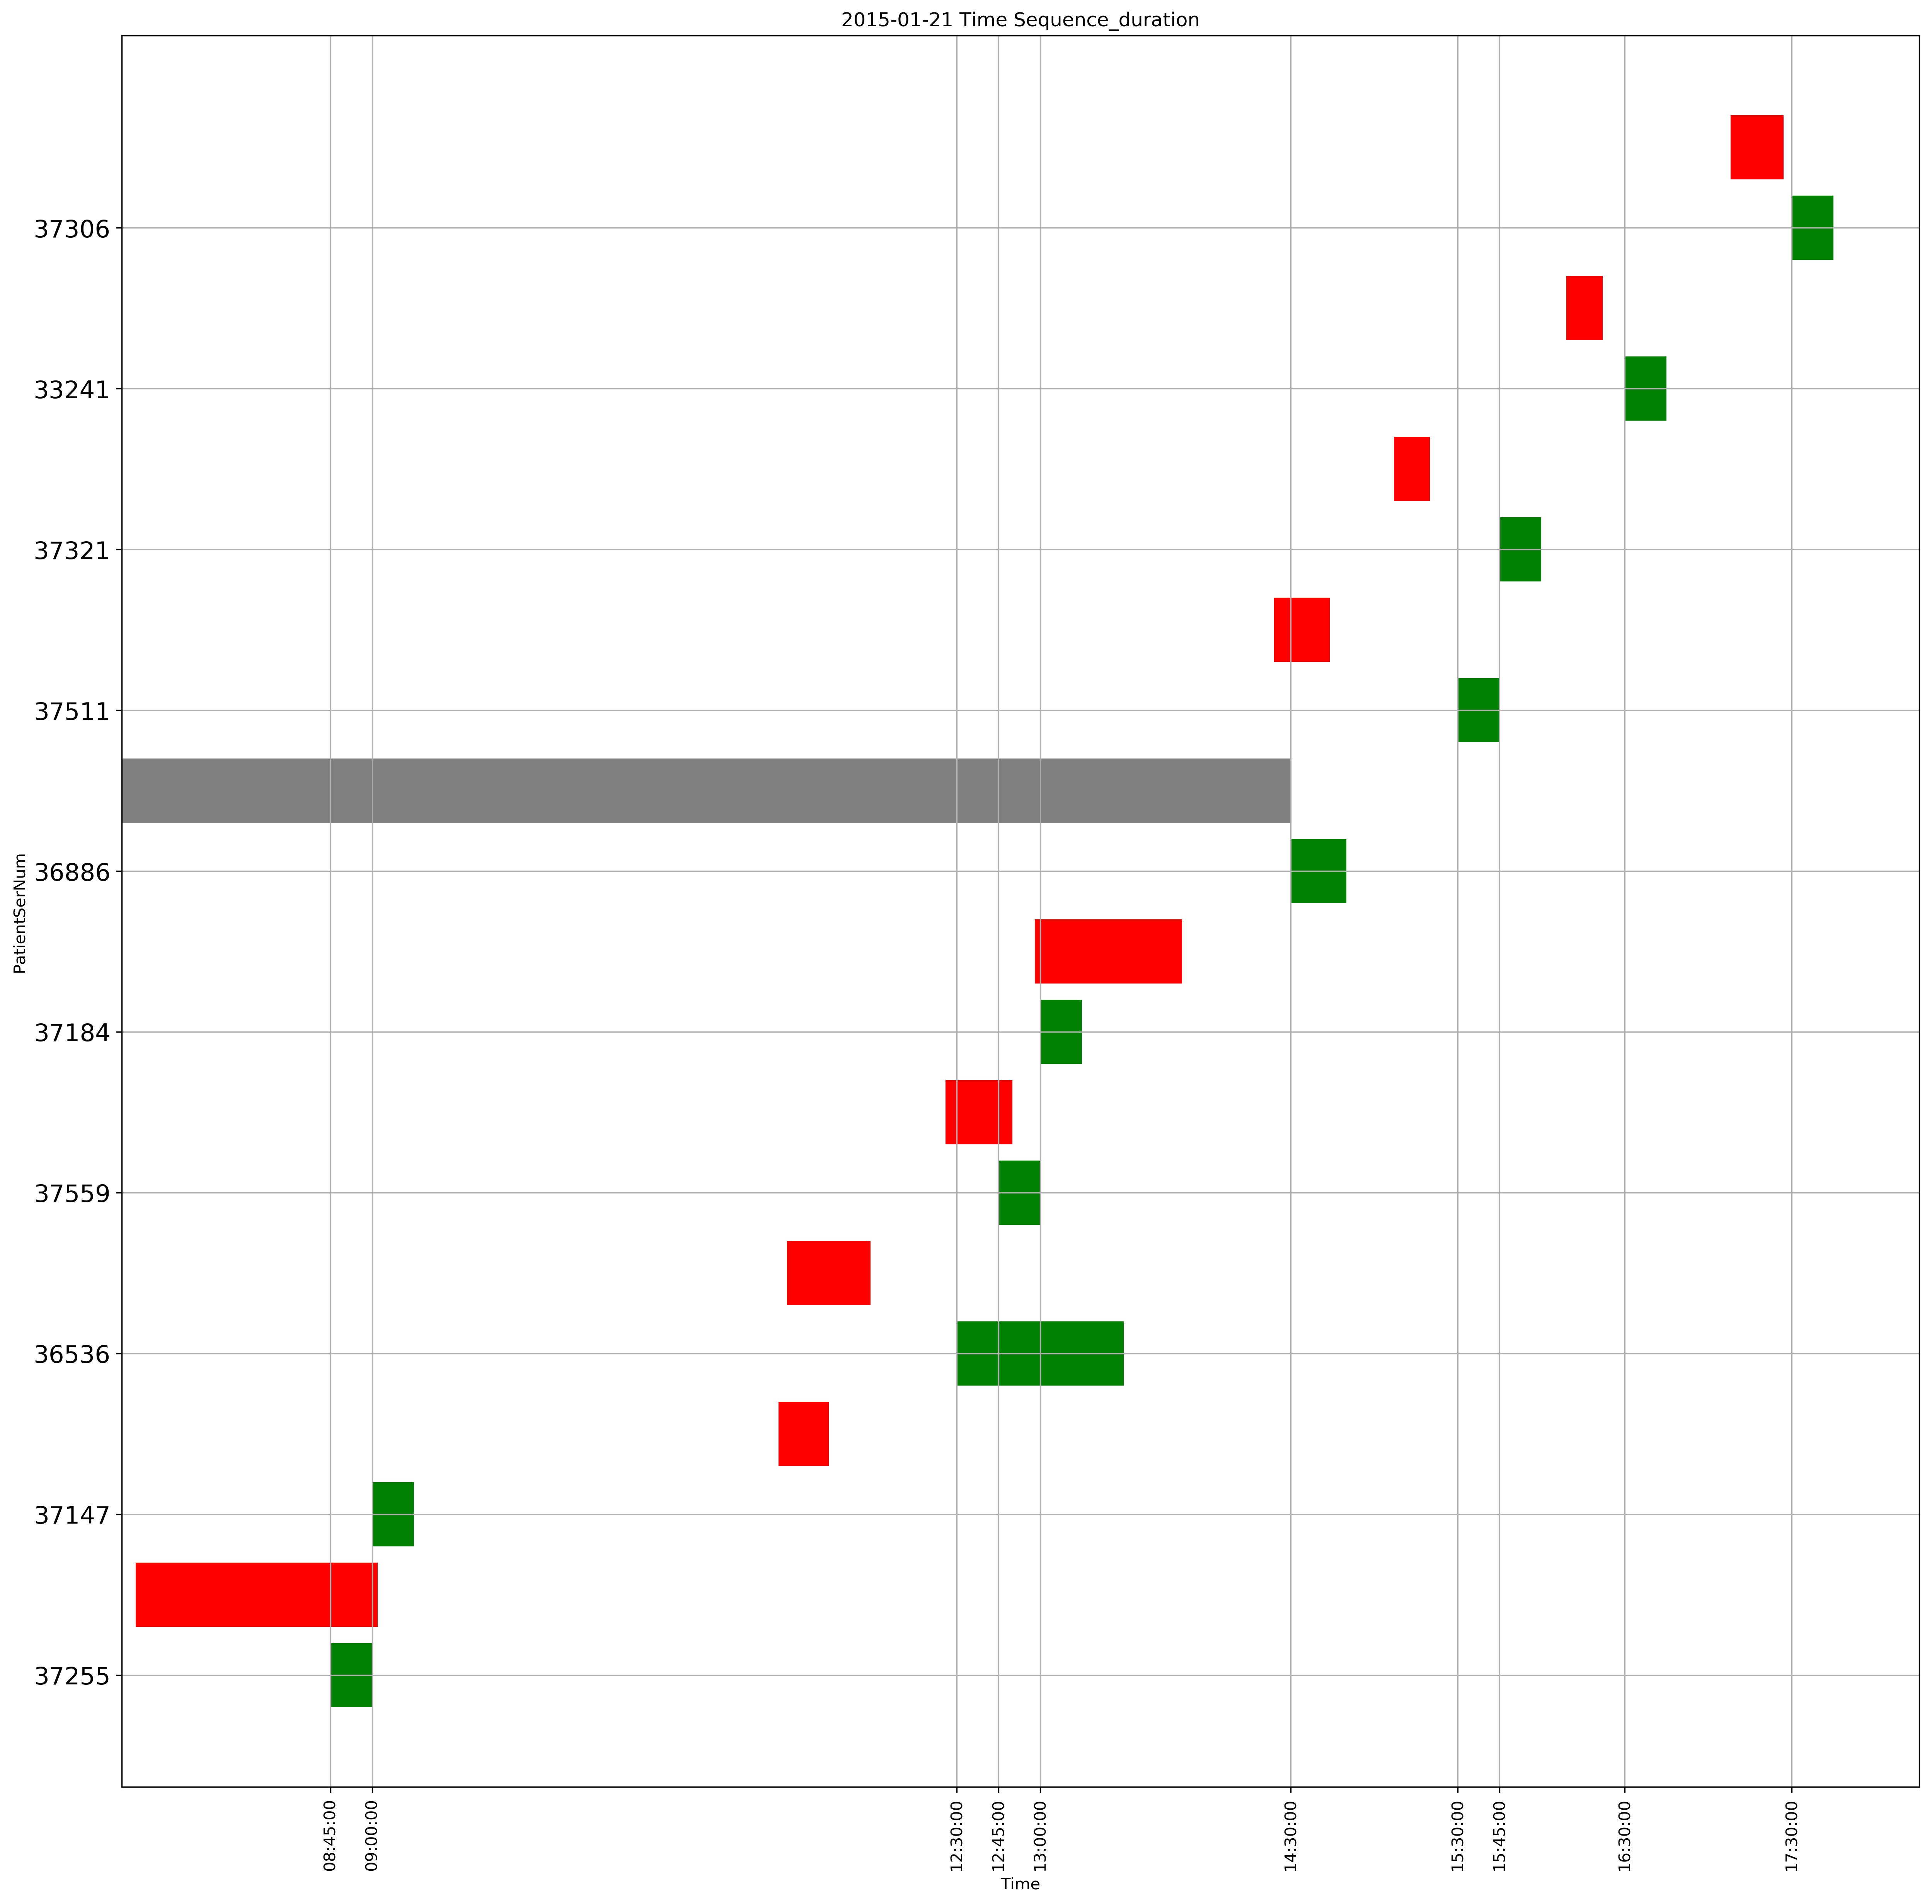

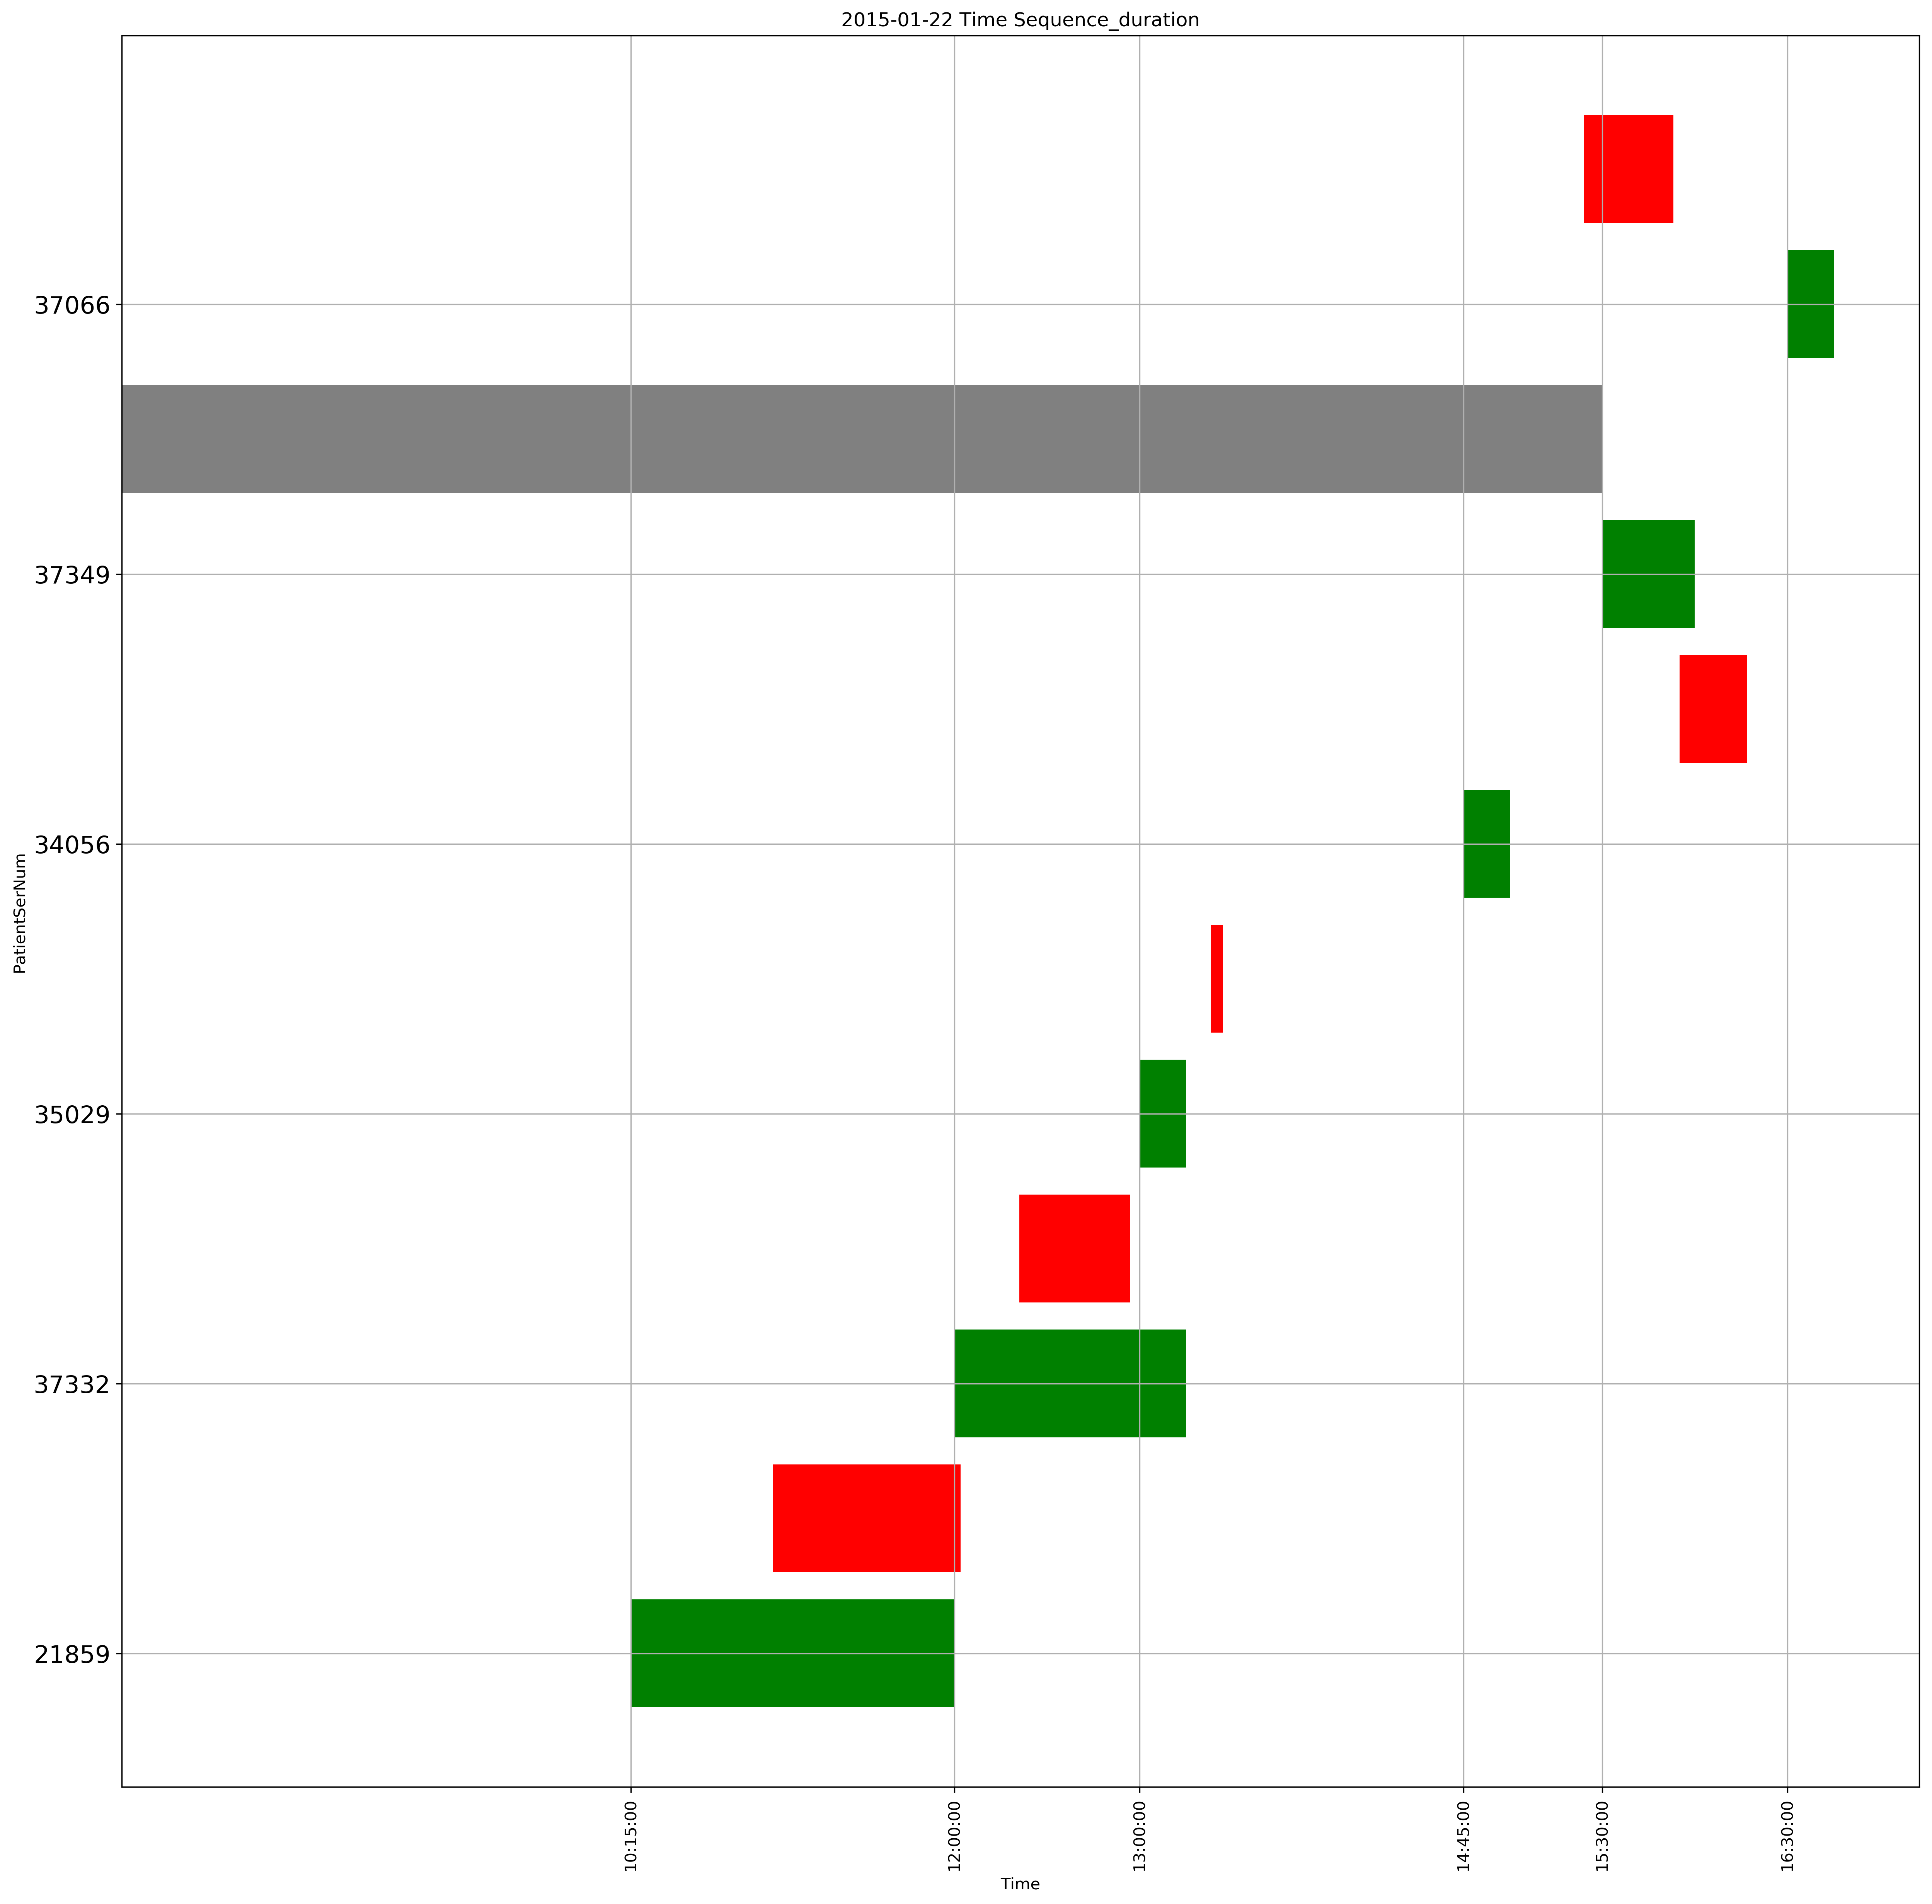

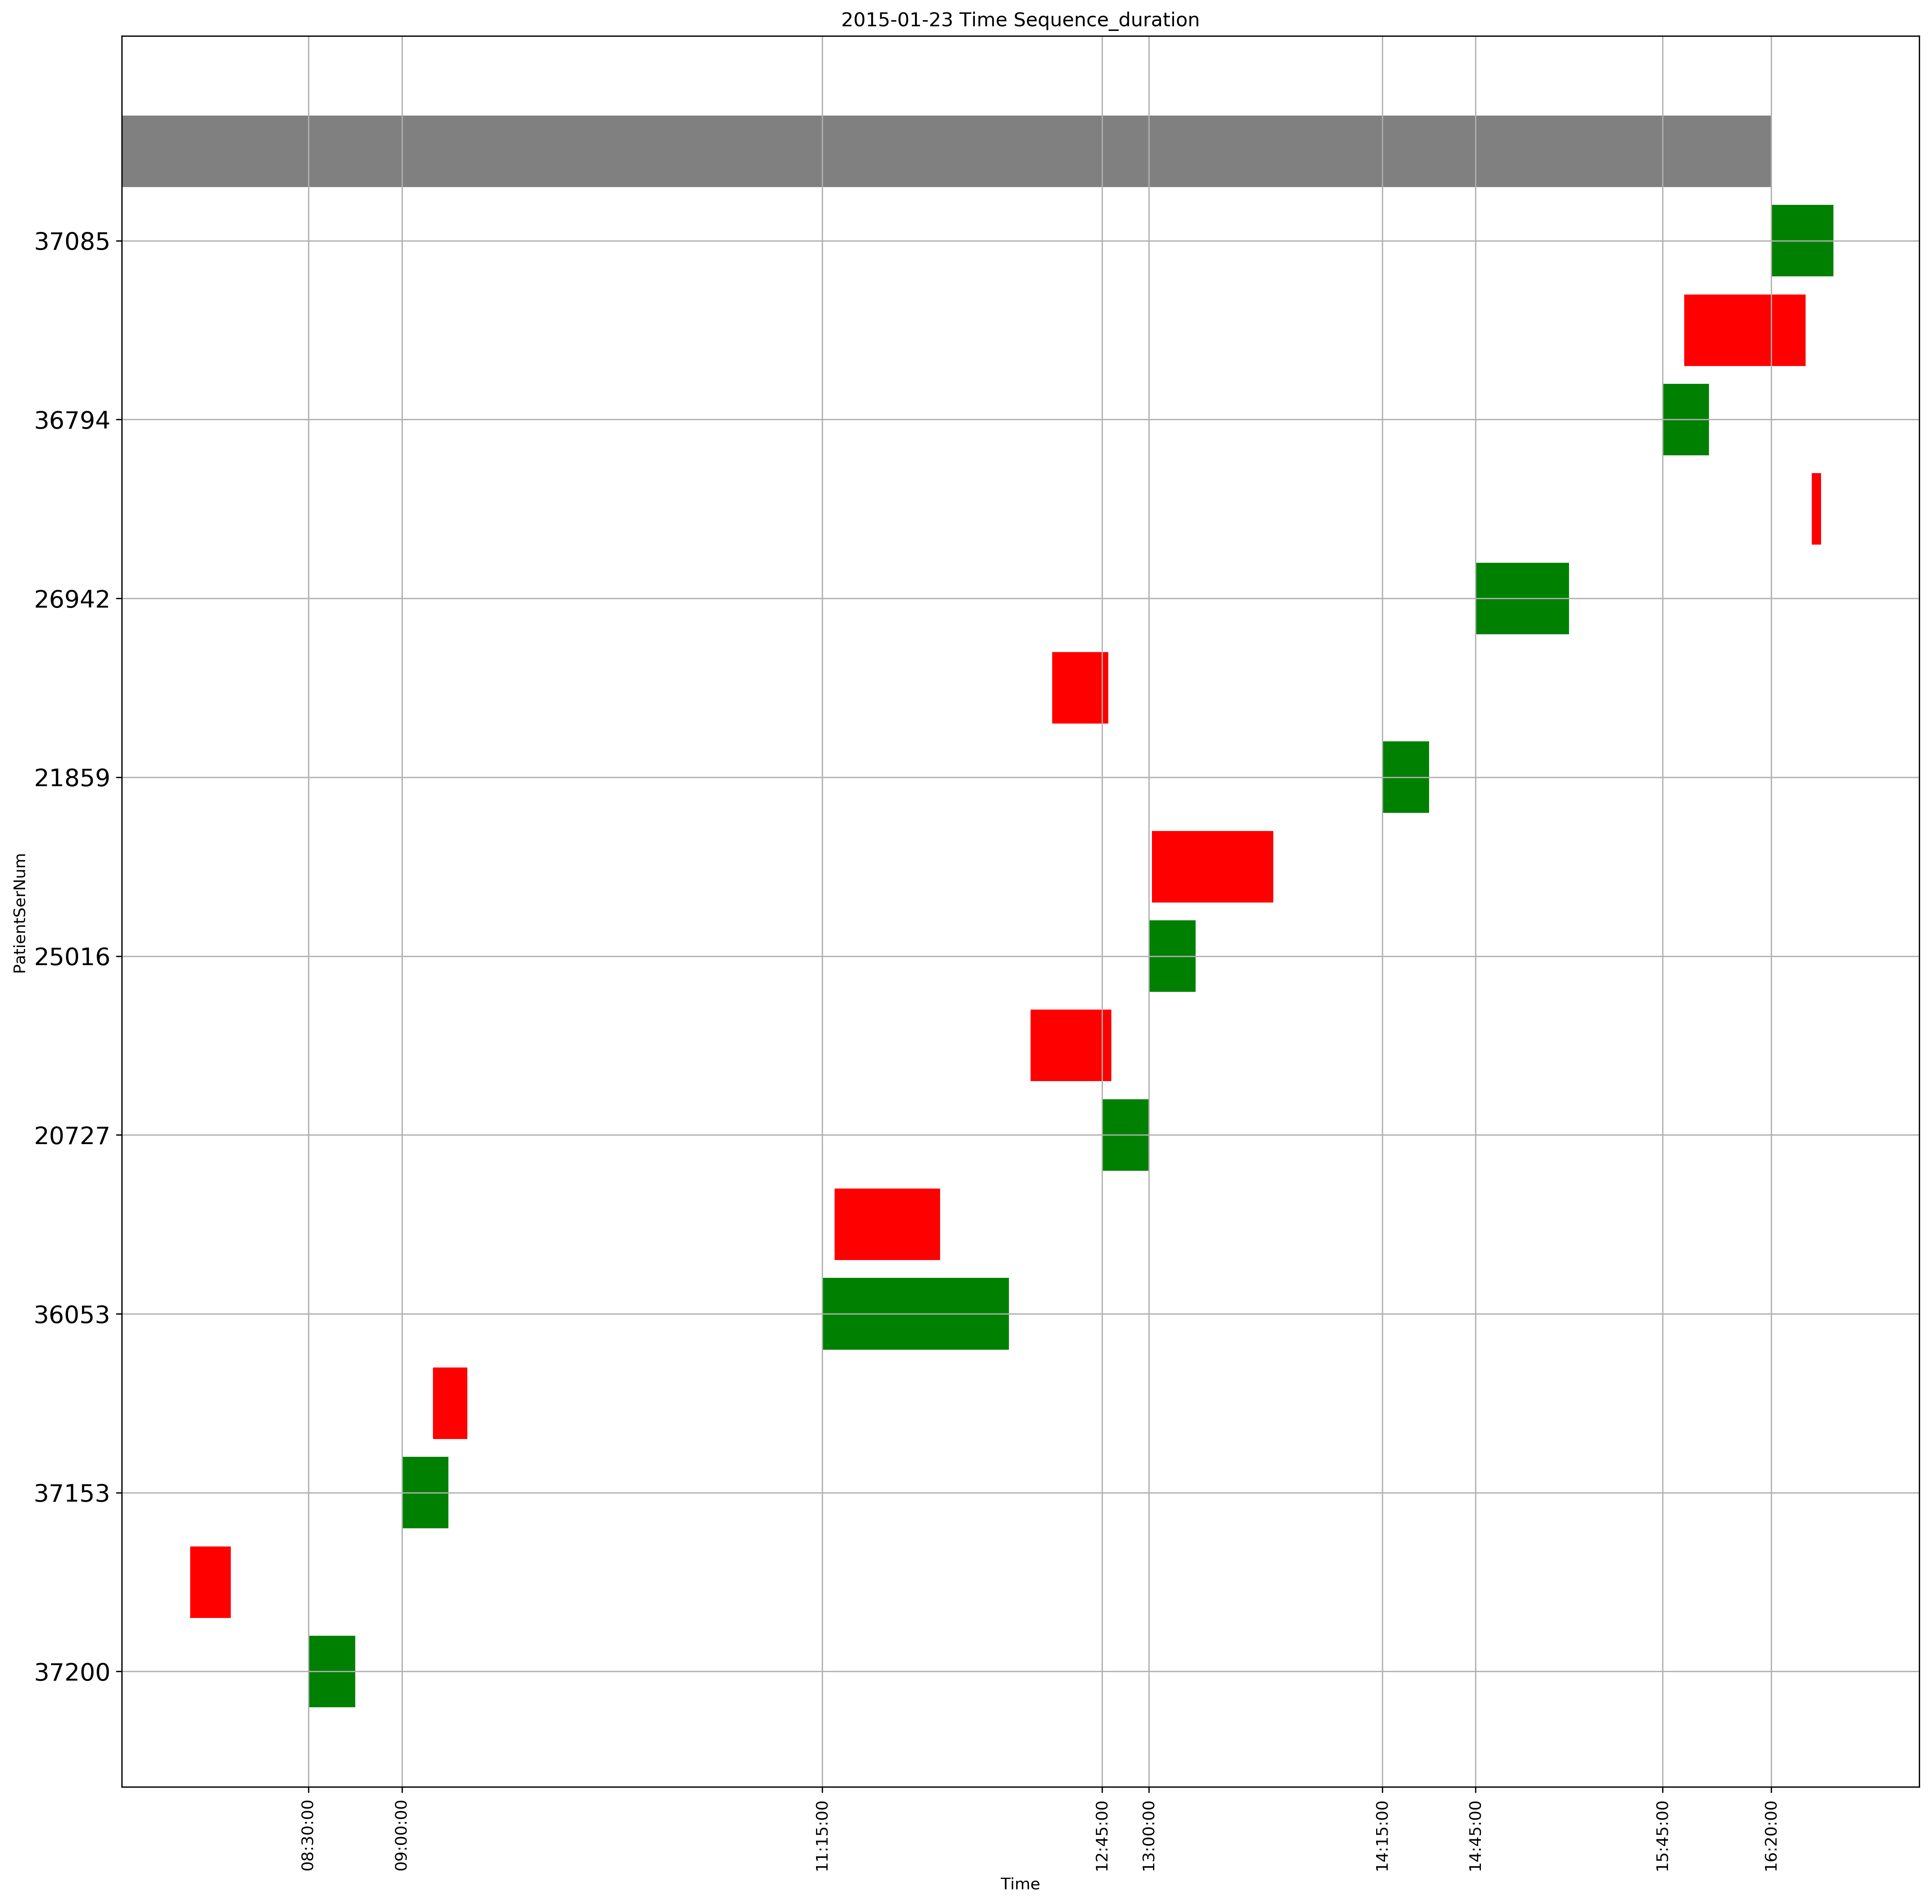

In [47]:
for time in datetime_same[10:15]:
    plotAndGetData(31, time)